In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

# Load the filtered PM2.5 dataset
filtered_pm25_path = "NYC EH Data Portal - Fine particles (PM 2.5) (filtered).csv"
filtered_pm25_data = pd.read_csv(filtered_pm25_path)

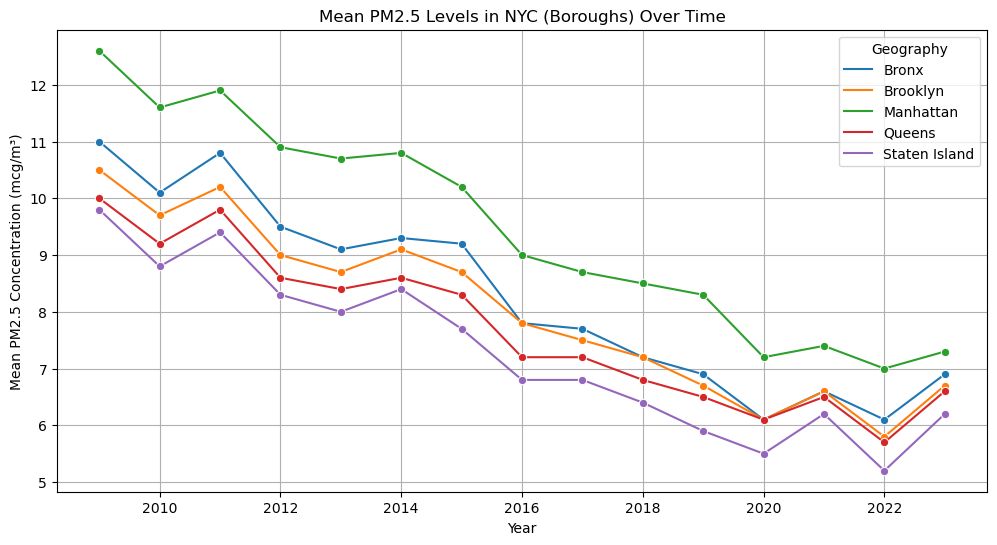

In [2]:
# Convert TimePeriod to extract year and season information
def extract_year_season(time_period):
    if "Annual Average" in time_period:
        return time_period.split()[-1], "Annual"
    elif any(season in time_period for season in ["Winter", "Spring", "Summer", "Fall"]):
        parts = time_period.split()
        return parts[-1], parts[0]  # Extract Year and Season
    return None, None

filtered_pm25_data["Year"], filtered_pm25_data["Season"] = zip(*filtered_pm25_data["TimePeriod"].apply(extract_year_season))

# Convert Year to numeric for filtering
filtered_pm25_data["Year"] = pd.to_numeric(filtered_pm25_data["Year"], errors='coerce')

# Filter data for NYC Citywide and Boroughs
boroughs = ["Bronx", "Brooklyn", "Manhattan", "Queens", "Staten Island"]
nyc_data = filtered_pm25_data[filtered_pm25_data["Geography"].isin(boroughs)]

# Select only annual data for consistency
annual_nyc_data = nyc_data[nyc_data["Season"] == "Annual"].dropna(subset=["Year", "Mean mcg/m3"])

# Plot Mean mcg/m3 over time for each borough
plt.figure(figsize=(12, 6))
sns.lineplot(data=annual_nyc_data, x="Year", y="Mean mcg/m3", hue="Geography", marker="o")

# Formatting the chart
plt.title("Mean PM2.5 Levels in NYC (Boroughs) Over Time")
plt.xlabel("Year")
plt.ylabel("Mean PM2.5 Concentration (mcg/m³)")
plt.legend(title="Geography")
plt.grid(True)

# Show the plot
plt.show()


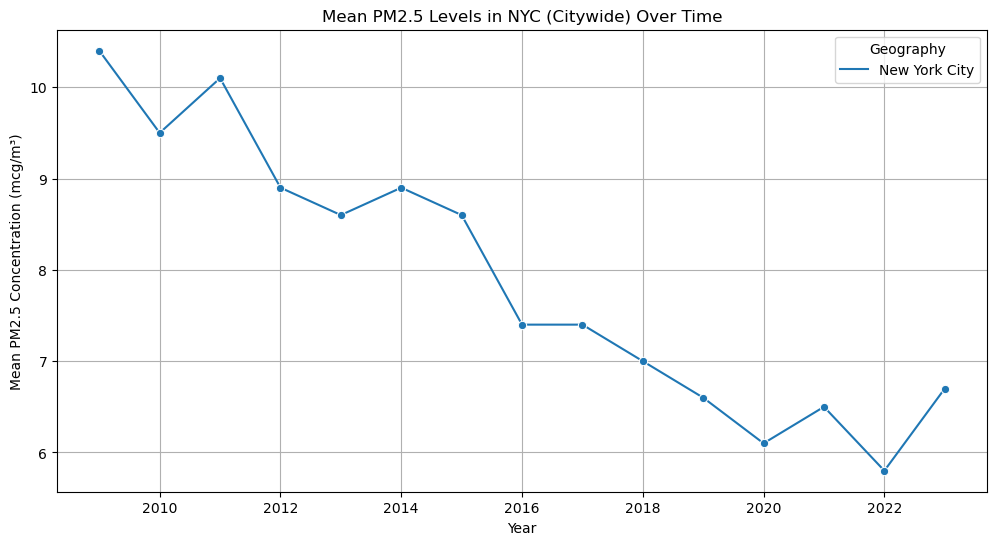

In [3]:
# Filter data for NYC Citywide and Boroughs
boroughs = ["New York City"]
nyc_data = filtered_pm25_data[filtered_pm25_data["Geography"].isin(boroughs)]

# Select only annual data for consistency
annual_nyc_data = nyc_data[nyc_data["Season"] == "Annual"].dropna(subset=["Year", "Mean mcg/m3"])

# Plot Mean mcg/m3 over time for each borough
plt.figure(figsize=(12, 6))
sns.lineplot(data=annual_nyc_data, x="Year", y="Mean mcg/m3", hue="Geography", marker="o")

# Formatting the chart
plt.title("Mean PM2.5 Levels in NYC (Citywide) Over Time")
plt.xlabel("Year")
plt.ylabel("Mean PM2.5 Concentration (mcg/m³)")
plt.legend(title="Geography")
plt.grid(True)

# Show the plot
plt.show()

In [4]:
# Extract Year and Season directly from the dataset
filtered_pm25_data["Season"] = filtered_pm25_data["TimePeriod"].str.extract(r'(Winter|Spring|Summer|Fall)')[0]
filtered_pm25_data["Year"] = pd.to_numeric(filtered_pm25_data["TimePeriod"].str.extract(r'(\d{4})')[0], errors='coerce')

# Adjust Winter years (e.g., Winter 2022-23 should be counted as 2022)
filtered_pm25_data.loc[filtered_pm25_data["Season"] == "Winter", "Year"] -= 1

# Filter data for NYC Citywide and Boroughs
boroughs = ["Citywide", "Bronx", "Brooklyn", "Manhattan", "Queens", "Staten Island"]
nyc_data = filtered_pm25_data[filtered_pm25_data["Geography"].isin(boroughs)]

# Function to plot separate seasonal boxplots
def plot_seasonal_boxplots(start_year, end_year):
    seasonal_data = nyc_data[(nyc_data["Year"] >= start_year) & (nyc_data["Year"] <= end_year)]
    selected_seasons = ["Winter", "Summer", "Annual"]
    
    for season in selected_seasons:
        plt.figure(figsize=(12, 6))
        if season == "Annual":
            season_data = nyc_data[(nyc_data["TimePeriod"].str.contains("Annual Average", na=False)) & (nyc_data["Year"] >= start_year) & (nyc_data["Year"] <= end_year)]
        else:
            season_data = seasonal_data[seasonal_data["Season"] == season]
        
        if not season_data.empty:
            ax = sns.boxplot(data=season_data, x="Geography", y="Mean mcg/m3")
            
            # Add summary statistics
            medians = season_data.groupby("Geography")["Mean mcg/m3"].median()
            means = season_data.groupby("Geography")["Mean mcg/m3"].mean()
            q1 = season_data.groupby("Geography")["Mean mcg/m3"].quantile(0.25)
            q3 = season_data.groupby("Geography")["Mean mcg/m3"].quantile(0.75)
            mins = season_data.groupby("Geography")["Mean mcg/m3"].min()
            maxs = season_data.groupby("Geography")["Mean mcg/m3"].max()
            
            for j, tick in enumerate(ax.get_xticks()):
                geo = ax.get_xticklabels()[j].get_text()
                ax.text(tick, medians[geo], f"Med: {medians[geo]:.2f}", horizontalalignment='center', size=10, color='black', weight='semibold')
                ax.text(tick, means[geo], f"Mean: {means[geo]:.2f}", horizontalalignment='center', size=10, color='blue', weight='semibold')
                ax.text(tick, q1[geo], f"Q1: {q1[geo]:.2f}", horizontalalignment='center', size=10, color='green', weight='semibold')
                ax.text(tick, q3[geo], f"Q3: {q3[geo]:.2f}", horizontalalignment='center', size=10, color='orange', weight='semibold')
                ax.text(tick, mins[geo], f"Min: {mins[geo]:.2f}", horizontalalignment='center', size=10, color='purple', weight='semibold')
                ax.text(tick, maxs[geo], f"Max: {maxs[geo]:.2f}", horizontalalignment='center', size=10, color='red', weight='semibold')
            
            plt.title(f"{season} PM2.5 Levels in NYC ({start_year}-{end_year})")
            plt.xlabel("Geography")
            plt.ylabel("Mean PM2.5 Concentration (mcg/m³)")
            plt.xticks(rotation=45)
            plt.grid(True)
        else:
            plt.title(f"No Data for {season} ({start_year}-{end_year})")
            plt.axis("off")
        
        plt.show()

# Create interactive widgets
start_year_widget = widgets.IntSlider(min=int(nyc_data["Year"].min()), max=int(nyc_data["Year"].max()), step=1, value=int(nyc_data["Year"].min()), description="Start Year")
end_year_widget = widgets.IntSlider(min=int(nyc_data["Year"].min()), max=int(nyc_data["Year"].max()), step=1, value=int(nyc_data["Year"].max()), description="End Year")

# Display widgets and interactive plot
display(widgets.interactive(plot_seasonal_boxplots, start_year=start_year_widget, end_year=end_year_widget))


interactive(children=(IntSlider(value=2007, description='Start Year', max=2023, min=2007), IntSlider(value=202…

In [5]:
# Filter data for NYC Citywide and Boroughs
boroughs = ["New York City"]
nyc_data = filtered_pm25_data[filtered_pm25_data["Geography"].isin(boroughs)]

# Function to plot seasonal boxplots for all boroughs and separate Citywide
def plot_seasonal_boxplots(start_year, end_year):
    seasonal_data = nyc_data[(nyc_data["Year"] >= start_year) & (nyc_data["Year"] <= end_year)]
    selected_seasons = ["Winter", "Summer", "Annual"]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for i, season in enumerate(selected_seasons):
        if season == "Annual":
            season_data = nyc_data[(nyc_data["TimePeriod"].str.contains("Annual Average", na=False)) & (nyc_data["Year"] >= start_year) & (nyc_data["Year"] <= end_year)]
        else:
            season_data = seasonal_data[seasonal_data["Season"] == season]
        
        if not season_data.empty:
            ax = sns.boxplot(data=season_data, x="Geography", y="Mean mcg/m3", ax=axes[i])
            
            # Add summary statistics
            medians = season_data.groupby("Geography")["Mean mcg/m3"].median()
            means = season_data.groupby("Geography")["Mean mcg/m3"].mean()
            q1 = season_data.groupby("Geography")["Mean mcg/m3"].quantile(0.25)
            q3 = season_data.groupby("Geography")["Mean mcg/m3"].quantile(0.75)
            mins = season_data.groupby("Geography")["Mean mcg/m3"].min()
            maxs = season_data.groupby("Geography")["Mean mcg/m3"].max()
            
            for j, tick in enumerate(ax.get_xticks()):
                geo = ax.get_xticklabels()[j].get_text()
                ax.text(tick, medians[geo], f"Med: {medians[geo]:.2f}", horizontalalignment='center', size=10, color='black', weight='semibold')
                ax.text(tick, means[geo], f"Mean: {means[geo]:.2f}", horizontalalignment='center', size=10, color='blue', weight='semibold')
                ax.text(tick, q1[geo], f"Q1: {q1[geo]:.2f}", horizontalalignment='center', size=10, color='green', weight='semibold')
                ax.text(tick, q3[geo], f"Q3: {q3[geo]:.2f}", horizontalalignment='center', size=10, color='orange', weight='semibold')
                ax.text(tick, mins[geo], f"Min: {mins[geo]:.2f}", horizontalalignment='center', size=10, color='purple', weight='semibold')
                ax.text(tick, maxs[geo], f"Max: {maxs[geo]:.2f}", horizontalalignment='center', size=10, color='red', weight='semibold')
            
            axes[i].set_title(f"{season} PM2.5 Levels in NYC ({start_year}-{end_year})")
            axes[i].set_xlabel("Geography")
            axes[i].set_ylabel("Mean PM2.5 Concentration (mcg/m³)")
            axes[i].tick_params(axis='x', rotation=45)
        else:
            axes[i].set_title(f"No Data for {season} ({start_year}-{end_year})")
            axes[i].axis("off")
    
    plt.tight_layout()
    plt.show()

# Create interactive widgets
start_year_widget = widgets.IntSlider(min=int(nyc_data["Year"].min()), max=int(nyc_data["Year"].max()), step=1, value=int(nyc_data["Year"].min()), description="Start Year")
end_year_widget = widgets.IntSlider(min=int(nyc_data["Year"].min()), max=int(nyc_data["Year"].max()), step=1, value=int(nyc_data["Year"].max()), description="End Year")

# Display widgets and interactive plot
display(widgets.interactive(plot_seasonal_boxplots, start_year=start_year_widget, end_year=end_year_widget))


interactive(children=(IntSlider(value=2007, description='Start Year', max=2023, min=2007), IntSlider(value=202…